In [1]:
# Install helmet-assignment helper code
# !pip install input/helmet-assignment-helpers/helmet-assignment-main/ > /dev/null 2>&1
from helmet_assignment.score import NFLAssignmentScorer, check_submission
from helmet_assignment.features import add_track_features

import numpy as np
import pandas as pd
import glob
import os
import cv2
import itertools
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
from multiprocessing import Pool
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import random
random.seed(42)
from matplotlib.pyplot import figure

import sys
sys.path.append('input/easydict-master/easydict-master/')
# https://github.com/mikel-brostrom/Yolov5_DeepSort_Pytorch
sys.path.append('input/yolov5-deepsort-pytorch/Yolov5_DeepSort_Pytorch-master/Yolov5_DeepSort_Pytorch-master/deep_sort_pytorch/')
from deep_sort.deep_sort import DeepSort
from utils.parser import get_config
from helmet_assignment.video import video_with_predictions
from IPython.display import Video, display


In [2]:
def plot_one_box(x, im, color=None, label=None, line_thickness=3):
    # Plots one bounding box on image 'im' using OpenCV
    assert im.data.contiguous, 'Image not contiguous. Apply np.ascontiguousarray(im) to plot_on_box() input image.'
    tl = line_thickness or round(0.002 * (im.shape[0] + im.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(im, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label: 
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(im, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(im, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    return im

In [3]:
def find_nearest(array, value): # находит значение ближайшего est_frame-а к value (фрэйму)
    value = int(value)
    array = np.asarray(array).astype(int)
    idx = (np.abs(array - value)).argmin() # из номеров est_frame вычитаем frame, берем модуль. Находим индекс минимального элемента в массиве
    return array[idx] # значение ближайшего est_frame-а

def create_triangle(center, sidelength): # The area of the triangle with sidelength=10 equals 40
    a_x = int(center[0] - sidelength/2)
    b_x = int(center[0] + sidelength/2)
    c_x = int(center[0])
    
    h = int(round(math.sqrt(sidelength**2 - (sidelength/2)**2)))
    a_y = int(center[1] - h/2)
    b_y = int(center[1] - h/2)
    c_y = int(center[1] + h/2)
    
    return np.array([[a_x, a_y], [b_x, b_y], [c_x, c_y]])

def modern_posit(image_pts, world_pts, focal_length, center):
    nb_points = np.shape(image_pts)[0]

    # centered & scaled pixel coordinates
    centered_image = np.divide(np.subtract(image_pts, center), focal_length)
    ui = centered_image[:, 0]
    vi = centered_image[:, 1]

    # homogeneous world coordinates
    homogeneous_world_pts = np.append(world_pts, np.ones((nb_points, 1)), 1)

    # pseudo inverse
    object_mat = np.linalg.pinv(homogeneous_world_pts)
    #print(object_mat)

    converged = 0
    count = 0
    t_x = 0.0
    t_y = 0.0
    t_z = 0.0
    r1 = 0.0
    r2 = 0.0
    r3 = 0.0
    while converged == 0:
        # POS part of the algorithm
        # rotation vectors
        r1_t = np.matmul(object_mat, ui)
        r2_t = np.matmul(object_mat, vi)
        # 1/t_z1 is norm of r1_t
        t_z1 = 1 / np.linalg.norm(r1_t[0:3])
        # 1/tz_2 is norm of r2_t
        t_z2 = 1 / np.linalg.norm(r2_t[0:3])
        
        # geometric average
        t_z = np.sqrt(t_z1 * t_z2)
        
        r1_n = np.multiply(r1_t, t_z)
        r2_n = np.multiply(r2_t, t_z)
        r1 = r1_n[0:3]
        r2 = r2_n[0:3]
        r3 = np.cross(r1, r2)
        r3_t = np.append(r3, t_z)
        t_x = r1_n[3]
        t_y = r2_n[3]

        # Now update the z/T z or epsilon
        # then ui, vi
        epsilon_i = np.matmul(homogeneous_world_pts, np.divide(r3_t, t_z))
        old_ui = ui
        old_vi = vi
        ui = np.multiply(epsilon_i, centered_image[:, 0])
        vi = np.multiply(epsilon_i, centered_image[:, 1])

        # check for convergence
        delta_ui = ui - old_ui
        delta_vi = vi - old_vi
        delta = np.square(focal_length) * (np.square(np.linalg.norm(delta_ui)) + np.square(np.linalg.norm(delta_vi)))

        converged = 1 if count > 0 and delta < 1 else 0
        count = count + 1
        if count > 1000:
            break

    trans = np.array([t_x, t_y, t_z], np.float64)
    rot = np.array([r1, r2, r3], np.float64)
    
    return rot, trans, count

def get_3d_angles(R):
    """
    Illustration of the rotation matrix / sometimes called 'orientation' matrix
    R = [ 
           R11 , R12 , R13, 
           R21 , R22 , R23,
           R31 , R32 , R33  
        ]

    REMARKS: 
    1. this implementation is meant to make the mathematics easy to be deciphered
    from the script, not so much on 'optimized' code. 
    You can then optimize it to your own style. 

    2. I have utilized naval rigid body terminology here whereby; 
    2.1 roll -> rotation about x-axis 
    2.2 pitch -> rotation about the y-axis 
    2.3 yaw -> rotation about the z-axis (this is pointing 'upwards') 
    https://stackoverflow.com/questions/15022630/how-to-calculate-the-angle-from-rotation-matrix
    """
    from math import asin, pi, atan2, cos 

    R11 = R[0][0]
    R12 = R[0][1]
    R13 = R[0][2]

    R21 = R[1][0]
    R22 = R[1][1]
    R23 = R[1][2]

    R31 = R[2][0]
    R32 = R[2][1]
    R33 = R[2][2]

    if R31 != 1 and R31 != -1:
        pitch_1 = -1*asin(R31)
        pitch_2 = pi - pitch_1 
        roll_1 = atan2( R32 / cos(pitch_1) , R33 /cos(pitch_1) ) 
        roll_2 = atan2( R32 / cos(pitch_2) , R33 /cos(pitch_2) ) 
        yaw_1 = atan2( R21 / cos(pitch_1) , R11 / cos(pitch_1) )
        yaw_2 = atan2( R21 / cos(pitch_2) , R11 / cos(pitch_2) ) 

        # IMPORTANT NOTE here, there is more than one solution but we choose the first for this case for simplicity !
        # You can insert your own domain logic here on how to handle both solutions appropriately (see the reference publication link for more info). 
        pitch = pitch_1 
        roll = roll_1
        yaw = yaw_1 
    else: 
        yaw = 0 # anything (we default this to zero)
        if R31 == -1: 
            pitch = pi/2 
            roll = yaw + atan2(R12,R13) 
        else: 
            pitch = -pi/2 
            roll = -1*yaw + atan2(-1*R12,-1*R13) 

    # convert from radians to degrees
    roll = roll*180/pi 
    pitch = pitch*180/pi
    yaw = yaw*180/pi 

    rxyz_deg = [roll , pitch , yaw]
    return rxyz_deg
    
import math

CONF_THRE = 0.3
debug = True

odd_helmets = pd.read_csv('tstr/mapping_posit-odd_helmets.csv', index_col='Unnamed: 0')
tracking = pd.read_csv('tstr/mapping_posit-tracking.csv', index_col='Unnamed: 0')
labels = pd.read_csv('tstr/mapping_posit-labels.csv', index_col='Unnamed: 0')

In [64]:
if os.environ['PWD'] == '/':
    ENTRY = 'input' # local run
if os.environ['PWD'] == '/kaggle/working':
    ENTRY = '../input' # kaggle run
    
BASE_DIR = f'{ENTRY}/nfl-health-and-safety-helmet-assignment'
part = '/train'

helmets = pd.read_csv(f'{BASE_DIR}{part}_baseline_helmets.csv')
helmets['helmet_size'] = helmets['width']*helmets['height']
helmets['video'] = helmets['video_frame'].apply(lambda x: '_'.join(x.split('_')[:3]))
helmets['frame'] = helmets['video_frame'].apply(lambda x: int(x.split('_')[-1]))
helmets['right'] = helmets['left'] + helmets['width']/2
helmets['down'] = helmets['top'] + helmets['height']/2
helmets['game_play'] = helmets['video'].apply(lambda x: '_'.join(x.split('_')[0:2]))
helmets['POV'] = helmets['video'].apply(lambda x: x.split('_')[2])

In [65]:
# helmets_mean = helmets.groupby(['game_play','POV','frame'], as_index=False)['helmet_size'].mean().sort_values('helmet_size')
helmets_mean = helmets.groupby(['video_frame'], as_index=False)['helmet_size'].mean().round(1).sort_values('helmet_size')
helmets_mean = helmets_mean.rename(columns = {'helmet_size':'helmet_mean'})
# helmets_median = helmets.groupby(['game_play','POV','frame'], as_index=False)['helmet_size'].median().sort_values('helmet_size')
helmets_median = helmets.groupby(['video_frame'], as_index=False)['helmet_size'].median().sort_values('helmet_size')
helmets_median = helmets_median.rename(columns={'helmet_size':'helmet_median'})

In [66]:
helmets_mndn = pd.merge(helmets_mean,helmets_median).sort_values('helmet_mean')
helmets_mndn

,video_frame,helmet_mean,helmet_median
0,57594_000923_Sideline_250,76.0,72.0
1,57594_000923_Sideline_249,76.4,72.0
2,57594_000923_Sideline_223,76.7,72.0
3,57594_000923_Sideline_244,76.8,72.0
4,57594_000923_Sideline_245,77.8,72.0
...,...,...,...
52136,57686_002546_Endzone_387,3909.8,4224.0
52137,57686_002546_Endzone_391,3962.9,4158.0
52138,57686_002546_Endzone_390,3963.1,4158.0
52139,57686_002546_Endzone_389,3965.3,4158.0


In [67]:
# output['xy_rel'] = output[['left','width','top','height']].apply(lambda x: np.linalg.norm([x.left+(x.width/2)-640,x.top+(x.height/2)-360]), axis=1).copy()
# output = output.sort_values('xy_rel').head(5).drop(columns=['xy_rel'])
# output

In [81]:
helmets.groupby('video_frame').count().sort_values('left')

,left,width,top,height,conf,helmet_size,video,frame,right,down,game_play,POV
video_frame,,,,,,,,,,,,
57584_000336_Sideline_461,2,2,2,2,2,2,2,2,2,2,2,2
57584_000336_Sideline_459,2,2,2,2,2,2,2,2,2,2,2,2
57584_000336_Sideline_441,2,2,2,2,2,2,2,2,2,2,2,2
57584_000336_Sideline_473,2,2,2,2,2,2,2,2,2,2,2,2
57584_000336_Sideline_462,2,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
58094_002819_Sideline_170,79,79,79,79,79,79,79,79,79,79,79,79
58094_000423_Sideline_241,79,79,79,79,79,79,79,79,79,79,79,79
58094_002819_Sideline_183,81,81,81,81,81,81,81,81,81,81,81,81


58102_002798_Sideline_300


/Users/apple/opt/anaconda3/envs/Py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/apple/opt/anaconda3/envs/Py37/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


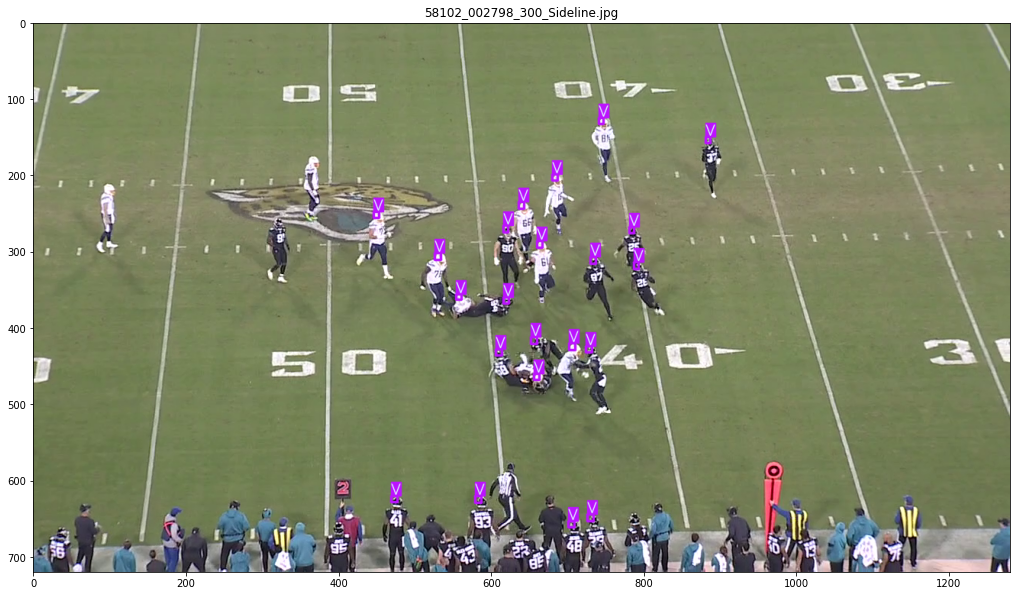

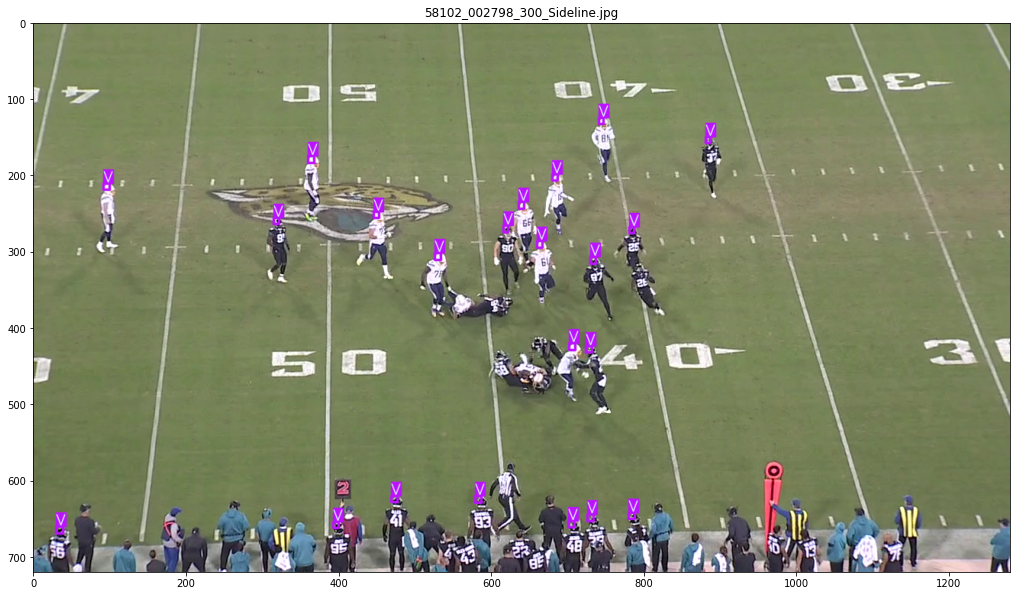

In [144]:
tst_image = helmets.sample(1).iloc[-1,:].video_frame #'58094_000423_Sideline_241'#'58005_001612_Sideline_423'# #'57583_000082_Sideline_235'
print(tst_image)
gameplay = '_'.join(tst_image.split('_')[:2])
view = tst_image.split('_')[2]
frame = int(tst_image.split('_')[3])
mypath = BASE_DIR + part

video_path = f'{mypath}/{gameplay}_{view}.mp4'
cap = cv2.VideoCapture(video_path) # обращаемся к видеофайлу
cap.set(cv2.CAP_PROP_POS_FRAMES, frame-1) # Устанавливаем индекс кадра, который будет извлекаться из видеопотока (индексация начинается от 0)
success, image = cap.read() # Считываем кадр(картинку) , метод возвращает флаг success (True , False) и image — саму картинку (массив numpy)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Меняем цветовое пространство на RGB
output = helmets[(helmets['game_play'] == gameplay) & (helmets['POV'] == view) & (helmets['frame'] == frame)]
output['xy_rel'] = output[['left','width','top','height']].apply(lambda x: np.linalg.norm([x.left+(x.width/2)-640,x.top+(x.height/2)-360]), axis=1).copy()
output = output[output['conf'] > 0.3]
output = output.sort_values('xy_rel').head(22)
# output = output.sort_values('conf').head(22)

for x in output.loc[:,['left', 'top', 'right','down']].values: # перебираем шлемы
    bboxes = list(x)
    # id = frame
    label = 'V'
    im = plot_one_box(bboxes, image, label=label,
                    #   color=(171, 6, 75), 
                        color=(188, 19, 254), 
                        line_thickness=2)
fig, ax = plt.subplots(figsize=(17.5, 12))
filename = gameplay+ '_' + str(frame) +'_'+view +'.jpg'
ax.set_title(filename)
plt.imshow(im)
# image_folder = 'videos_annotation'+part
# plt.savefig(image_folder+'/'+filename,dpi = 100)
# plt.close(fig)

video_path = f'{mypath}/{gameplay}_{view}.mp4'
cap = cv2.VideoCapture(video_path) # обращаемся к видеофайлу
cap.set(cv2.CAP_PROP_POS_FRAMES, frame-1) # Устанавливаем индекс кадра, который будет извлекаться из видеопотока (индексация начинается от 0)
success, image = cap.read() # Считываем кадр(картинку) , метод возвращает флаг success (True , False) и image — саму картинку (массив numpy)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Меняем цветовое пространство на RGB
output = helmets[(helmets['game_play'] == gameplay) & (helmets['POV'] == view) & (helmets['frame'] == frame)]
output['xy_rel'] = output[['left','width','top','height']].apply(lambda x: np.linalg.norm([x.left+(x.width/2)-640,x.top+(x.height/2)-360]), axis=1).copy()
output = output[output['conf'] > 0.3]
output = output.sort_values('conf').tail(22)
# output = output.sort_values('conf').head(22)

for x in output.loc[:,['left', 'top', 'right','down']].values: # перебираем шлемы
    bboxes = list(x)
    # id = frame
    label = 'V'
    im = plot_one_box(bboxes, image, label=label,
                    #   color=(171, 6, 75), 
                        color=(188, 19, 254), 
                        line_thickness=2)
fig, ax = plt.subplots(figsize=(17.5, 12))
filename = gameplay+ '_' + str(frame) +'_'+view +'.jpg'
ax.set_title(filename)
plt.imshow(im)

In [95]:
helmets[helmets['video_frame'] == '58094_000423_Sideline_241'].sort_values('conf').head(30)

,video_frame,left,width,top,height,conf,helmet_size,video,frame,right,down,game_play,POV
961963,58094_000423_Sideline_241,0,5,57,10,0.052155,50,58094_000423_Sideline,241,2.5,62.0,58094_000423,Sideline
961964,58094_000423_Sideline_241,446,8,67,10,0.052246,80,58094_000423_Sideline,241,450.0,72.0,58094_000423,Sideline
961965,58094_000423_Sideline_241,606,12,350,12,0.054657,144,58094_000423_Sideline,241,612.0,356.0,58094_000423,Sideline
961966,58094_000423_Sideline_241,483,12,712,8,0.057129,96,58094_000423_Sideline,241,489.0,716.0,58094_000423,Sideline
961967,58094_000423_Sideline_241,508,8,30,15,0.057343,120,58094_000423_Sideline,241,512.0,37.5,58094_000423,Sideline
961968,58094_000423_Sideline_241,0,8,41,11,0.059967,88,58094_000423_Sideline,241,4.0,46.5,58094_000423,Sideline
961969,58094_000423_Sideline_241,558,10,296,16,0.065796,160,58094_000423_Sideline,241,563.0,304.0,58094_000423,Sideline
961970,58094_000423_Sideline_241,357,10,20,10,0.071594,100,58094_000423_Sideline,241,362.0,25.0,58094_000423,Sideline
961971,58094_000423_Sideline_241,282,10,22,9,0.073120,90,58094_000423_Sideline,241,287.0,26.5,58094_000423,Sideline
961972,58094_000423_Sideline_241,509,9,18,11,0.075012,99,58094_000423_Sideline,241,513.5,23.5,58094_000423,Sideline


In [8]:
helmets_mndn

,video_frame,helmet_mean,helmet_median
0,57594_000923_Sideline_250,76.0,72.0
1,57594_000923_Sideline_249,76.4,72.0
2,57594_000923_Sideline_223,76.7,72.0
3,57594_000923_Sideline_244,76.8,72.0
4,57594_000923_Sideline_245,77.8,72.0
...,...,...,...
52136,57686_002546_Endzone_387,3909.8,4224.0
52137,57686_002546_Endzone_391,3962.9,4158.0
52138,57686_002546_Endzone_390,3963.1,4158.0
52139,57686_002546_Endzone_389,3965.3,4158.0


In [9]:
helmets_new = pd.merge(helmets, helmets_mndn)

In [10]:
helmets_new

,video_frame,left,width,top,height,conf,helmet_size,video,frame,right,down,game_play,POV,helmet_mean,helmet_median
0,57778_004244_Endzone_1,598,18,278,18,0.080017,324,57778_004244_Endzone,1,616,296,57778_004244,Endzone,488.6,493.0
1,57778_004244_Endzone_1,856,16,294,22,0.089050,352,57778_004244_Endzone,1,872,316,57778_004244,Endzone,488.6,493.0
2,57778_004244_Endzone_1,314,21,262,26,0.153076,546,57778_004244_Endzone,1,335,288,57778_004244,Endzone,488.6,493.0
3,57778_004244_Endzone_1,304,21,280,20,0.821289,420,57778_004244_Endzone,1,325,300,57778_004244,Endzone,488.6,493.0
4,57778_004244_Endzone_1,585,19,290,19,0.828613,361,57778_004244_Endzone,1,604,309,57778_004244,Endzone,488.6,493.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225167,57679_003316_Endzone_336,1002,47,210,48,0.861328,2256,57679_003316_Endzone,336,1049,258,57679_003316,Endzone,1696.6,1849.0
1225168,57679_003316_Endzone_336,898,46,345,54,0.866699,2484,57679_003316_Endzone,336,944,399,57679_003316,Endzone,1696.6,1849.0
1225169,57679_003316_Endzone_336,1064,50,276,48,0.870117,2400,57679_003316_Endzone,336,1114,324,57679_003316,Endzone,1696.6,1849.0
1225170,57679_003316_Endzone_336,352,48,462,46,0.875000,2208,57679_003316_Endzone,336,400,508,57679_003316,Endzone,1696.6,1849.0
